In [16]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#!/usr/bin/env python
# coding: utf-8
# Se importan librerías
import cv2 # OpenCV
import tensorflow as tf
import numpy as np # Arrays y matrices
import pandas as pd # Manipulación de datos
import matplotlib.pyplot as plt # Gráficas
import matplotlib.image as mpimg # Mostrar imágenes
import os # Sistema de archivos
from sklearn.model_selection import train_test_split # Entreno-Validación 
import random # Números aleatorios
import gc # Limpiar y borrar variables

In [0]:
# Directorios de entrenamiento y testeo:
entreno_dir = '/content/drive/My Drive/train/'

# Se extraen imágenes de entreno de perros y gatos por separado:
entreno_perros = ['/content/drive/My Drive/train/{}'.format(i) for i in os.listdir(entreno_dir) if 'dog' in i]
entreno_gatos = ['/content/drive/My Drive/train/{}'.format(i) for i in os.listdir(entreno_dir) if 'cat' in i]
# os.listdir coge todas las imágenes

# Se corta el dataset de entreno y se cogen 2000 imágenes de cada clase:
entreno_imagenes = entreno_perros[:2000] + entreno_gatos[:2000]
# Se barajan estas 4000 imágenes de forma aleatoria:
random.shuffle(entreno_imagenes)

# Se borran variables que ya no hacen falta para ahorrar memoria:
del entreno_perros
del entreno_gatos
gc.collect()

# Todas las imágenes a la misma dimensión:
alto = 180
ancho = 180
canales = 3 # Imágenes a color (RGB) = 3

In [0]:
# Se redimensiona las imagenes y se crea las etiquetas:
x = [] # Imágenes redimensionadas
y = [] # Etiquetas
for imagen in entreno_imagenes: # Bucle for
    # Leer y redimensionar imagen:
    x.append(cv2.resize(cv2.imread(imagen,cv2.IMREAD_COLOR),(alto,ancho),interpolation=cv2.INTER_CUBIC))
    # Obtener las etiquetas:
    if 'dog' in imagen:
        y.append(1) # No valen strings
    elif 'cat' in imagen:
        y.append(0)
# 'x' es ahora un array de valores de pixeles de cada imagen. 
# 'y' es una lista de dos etiquetas (0 o 1)

# Convertir a arrays numpy para manipular los datos
x = np.array(x)
y = np.array(y)

In [20]:
# Repartir los datos entre entrenamiento y validación
# 80% entreno, 20% validación:
x_entreno,x_valid,y_entreno,y_valid = train_test_split(x,y,test_size=0.20,random_state=2)

# Se borran variables ya inservibles:
del entreno_imagenes
del x
del y
gc.collect()

# Construir la red neuronal. Paquetes importados:
from keras import layers # Capas
from keras import models # Modelo secuencial

"""Entrada de 180x180x3, como las imágenes redimensionadas.
3 capas de convolución (ventanas 5x5) y 3 capas de max pooling (ventanas 3x3).
1 capa para aplanar el tensor a 1D y poder utilizar 2 capas densamente conectadas. 
Capa final con activación sigmoide al tratar la red solamente con dos clases: """
modelo = models.Sequential()
modelo.add(layers.Conv2D(32,(5,5),activation='relu',input_shape=(alto,ancho,canales)))
modelo.add(layers.MaxPooling2D((3,3)))
modelo.add(layers.Conv2D(64,(5,5),activation='relu'))
modelo.add(layers.MaxPooling2D((3,3)))
modelo.add(layers.Conv2D(128,(5,5),activation='relu'))
modelo.add(layers.MaxPooling2D((3,3)))
modelo.add(layers.Flatten()),
modelo.add(layers.Dense(512,activation='relu')),
modelo.add(layers.Dense(1,activation='sigmoid'))
modelo.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 176, 176, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [0]:
from keras import optimizers # Optimizadores

# Solo hay dos clases, por eso se utiliza esta función de coste
# Se utiliza un LR pequeño y la precisión como métrica:
modelo.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(lr = 0.0001),
               metrics=['acc'])

# Genera tensores procesados a partir de archivos de imagenes
# Reescala los pixeles de imágenes entre (0,1) y hace data augmentation:
from keras.preprocessing.image import ImageDataGenerator

""" Data augmentation. Previene el sobreajuste aumentando el dataset haciendo pequeñas 
variaciones en las imágenes de entreno (no utiliza las originales): """
entreno_pixel = ImageDataGenerator(rescale=1.0/255, # Normaliza el valor de los Px (0-1)
                                 rotation_range=40, # Ángulo para rotaciones aleatorias
                                 width_shift_range=0.2, # Rango traslación imagen 
                                 height_shift_range=0.2, # Rango traslación imagen
                                 shear_range=0.2, # Transformaciones de corte al azar
                                 zoom_range=0.2, # Zoom aleatorio
                                 horizontal_flip=True) # Gira aleatoriamente imágenes

# Solo reescalado de pixeles. Sin data augmentation:
valid_pixel = ImageDataGenerator(rescale=1.0/255)

# Tamaño de lotes de paquetes. Normalmente 32 (producto de 2's):
tamano_lote = 32

"""Se instancian generadores de lotes de las imágenes modificadas de los
datasets con los pixeles (0-1) y el data augmentation con el método flow: """
entreno_generador = entreno_pixel.flow(x_entreno,y_entreno,batch_size = tamano_lote)
valid_generador = valid_pixel.flow(x_valid,y_valid,batch_size = tamano_lote)

# Longitud de las imágenes de entreno y validación:
longitud_entreno = len(x_entreno)
longitud_valid = len(x_valid)

Epoch 1/150
 - 27s - loss: 0.6904 - acc: 0.5322 - val_loss: 0.6831 - val_acc: 0.5138
Epoch 2/150
 - 23s - loss: 0.6779 - acc: 0.5728 - val_loss: 0.7250 - val_acc: 0.5437
Epoch 3/150
 - 23s - loss: 0.6693 - acc: 0.5863 - val_loss: 0.6333 - val_acc: 0.5375
Epoch 4/150
 - 23s - loss: 0.6613 - acc: 0.5953 - val_loss: 0.5930 - val_acc: 0.6600
Epoch 5/150
 - 23s - loss: 0.6499 - acc: 0.6228 - val_loss: 0.5389 - val_acc: 0.5788
Epoch 6/150
 - 23s - loss: 0.6373 - acc: 0.6300 - val_loss: 0.4894 - val_acc: 0.6012
Epoch 7/150
 - 23s - loss: 0.6272 - acc: 0.6394 - val_loss: 0.6299 - val_acc: 0.7075
Epoch 8/150
 - 23s - loss: 0.6184 - acc: 0.6606 - val_loss: 0.5938 - val_acc: 0.7063
Epoch 9/150
 - 23s - loss: 0.6083 - acc: 0.6625 - val_loss: 0.4493 - val_acc: 0.7025
Epoch 10/150
 - 23s - loss: 0.6000 - acc: 0.6747 - val_loss: 0.5040 - val_acc: 0.7300
Epoch 11/150
 - 23s - loss: 0.5922 - acc: 0.6816 - val_loss: 0.3967 - val_acc: 0.7400
Epoch 12/150
 - 23s - loss: 0.5906 - acc: 0.6762 - val_loss: 0.

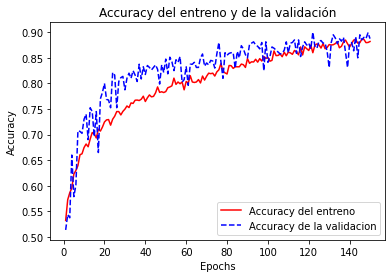

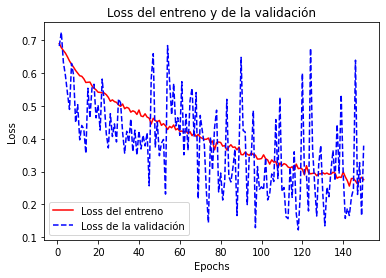

In [24]:
# Entreno de la red neuronal:
# Primer parámetro el set de entrenamiento de ImageDataGenerator
# Segundo cuantas imagenes procesar antes de actualizar función de pérdida
# Tercero número de epochs. Cuarto datos de validación y quinto, sus pasos
entrenamiento = modelo.fit_generator(entreno_generador,
                               steps_per_epoch = longitud_entreno // tamano_lote,
                               epochs = 150,
                               validation_data = valid_generador,
                               validation_steps = longitud_valid // tamano_lote,
                                    verbose = 2)

# Gráfica para comprobar si hay o no sobreajuste:
# Las métricas del entreno se guardan dentro del método 'history'
acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']
loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']
epochs = range(1,len(acc)+1,1)

# Accuracy del entreno y de la validación
plt.plot(epochs,acc,'r',label='Accuracy del entreno')
plt.plot(epochs, val_acc,'b--',label='Accuracy de la validacion')
plt.title('Accuracy del entreno y de la validación')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()

# Loss del entreno y de la validación
plt.plot(epochs,loss,'r',label='Loss del entreno')
plt.plot(epochs,val_loss,'b--',label='Loss de la validación')
plt.title('Loss del entreno y de la validación')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

modelo.save('modelo.h5')